This notebook conducts the forecasting for the baseline case to see how often the GR data vector is correctly identified as GR. We ignore photo-z error and IA for now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fiducial as fid
import utils as u
import scipy.stats 
from scipy.stats import chi2
from scipy.stats import rv_histogram
import specs as sp 

Define all the stuff we need:

In [ ]:
# Parameters
lens = 'DESI'
src = 'LSST'
Pimax=900.
rp0 = 1.5

# Number of E_G samples to draw:
#Nsamp = 1000

endfilename = 'test_EG_Gaussianity_Jul25'

# Use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

OmM = 0.292

# Using now nonliner bias parameters as fit in Kitanis & White 2022. 
# They fit LTP parameters so we convert these to their Eulerian equivalents.
b1_LPT = 1.333
b2_LPT = 0.514
bs_LPT = 0 # They fix this to 0.

# Convert to Eulerian using the conversions in Chen, Vlah & White 2020 (these use the same convention as Kitanis & White 2022)
b1 = 1.0 + b1_LPT
b2 = b2_LPT + 8./21.*(b1_LPT)
bs = bs_LPT - 2./7*(b1_LPT)

#b1 = 2.03
#b2 = 0.9*(b1-1.0)**2-0.5 # From Fast-PT example notebook which says 
#'(this is a numerical fit to simulation k2Pnl1_regdata, but a relationship of this form is motivated in the spherical collapse picture'
#bs = -4.0/7.0*(b1-1.0) # The 'coevolution value' see Pandey et al. DES Y3 papers

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965, 'A_s':2.115 * 10**(-9),'b':b1, 'OmM': 0.292, 'b_2':b2, 'b_s': bs} 

#Nsamps=100000

print('b1=', b1)
print('b2=', b2)
print('bs=', bs)

b1= 2.333
b2= 1.021809523809524
bs= -0.38085714285714284


In [3]:
# Compute the mean redshift over the lenses, we need this later:

zvec, dNdz = sp.get_dNdzL(params, 'DESI')

zbar = scipy.integrate.simps(zvec*dNdz, zvec)
print(zbar)

0.7226958808077818


In [4]:
# Scale cuts. 0 means cut the bin, 1 means keep it.
#rp_c_scalecuts, scalecuts = np.loadtxt('../txtfiles/scalecuts_nLbias_KitanidisWhite2022.dat', unpack=True)

rp_bin_c_raw = np.loadtxt('../data_for_Danielle/test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
rp_bin_edges_raw = u.rp_bin_edges_log(rp_bin_c_raw)

#Cut the bin containing rp0 and lower.
ind = next(j[0] for j in enumerate(rp_bin_edges_raw) if j[1]>rp0)
rp_bin_c = rp_bin_c_raw[ind:]
rp_bin_edges = rp_bin_edges_raw[ind:]

print('rp bin c=', rp_bin_c)
print('rp bin edges=', rp_bin_edges)

rp bin c= [ 1.83709466  2.42176242  3.19250463  4.20854074  5.54793718  7.31360558  9.64120984 12.70958983 16.75450244 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
rp bin edges= [  1.60004256   2.10926689   2.78055529   3.66548575   4.83205129   6.36988417   8.39714273  11.06958999  14.5925616   19.23674266  25.35896564  33.42962733  44.0688315   58.09403408  76.5828519  100.95586057]


Compute the fiducial values of the data vector at these parameters (nonlinear matter, no nonlinear bias)

In [6]:
data_nl_jp = fid.jp_datavector(params, rp_bin_edges, rp0, lens,src, Pimax, endfilename, nonlin = True, nl_bias=False)

maxchi= 6669.353003473356


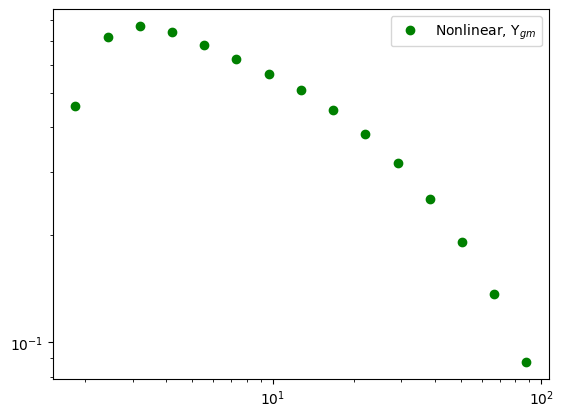

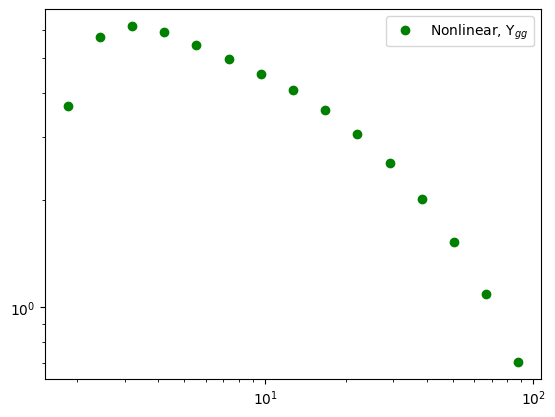

beta, nl= 0.342906677696308


In [8]:
plt.figure()
plt.loglog(rp_bin_c, data_nl_jp[0:len(rp_bin_c)], 'go', label='Nonlinear, $\\Upsilon_{gm}$')
plt.legend()
plt.show()

plt.figure()
plt.loglog(rp_bin_c, data_nl_jp[len(rp_bin_c):2*len(rp_bin_c)], 'go', label='Nonlinear, $\\Upsilon_{gg}$')
plt.legend()
plt.show()

# Check that beta is the same in the linear or nonlinear case
print("beta, nl=", data_nl_jp[-1])

In [ ]:
# Load the covariance matrix for the joint probes:
cov = np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Jul2025.dat')

In [20]:
# Draw data vector samples:

# Draw E_G realisations
Nsamp = 100000
dvec_samps = np.random.multivariate_normal(data_nl_jp, cov, Nsamp)

print(dvec_samps.shape)

(100000, 31)


In [21]:
# Get E_G from each sample

EG_samps_from_dvec = np.zeros((Nsamp, 15))
for i in range(0,Nsamp):
    EG_samps_from_dvec[i,:] = dvec_samps[i,0:15] / (dvec_samps[i,15:30]*dvec_samps[i,30])

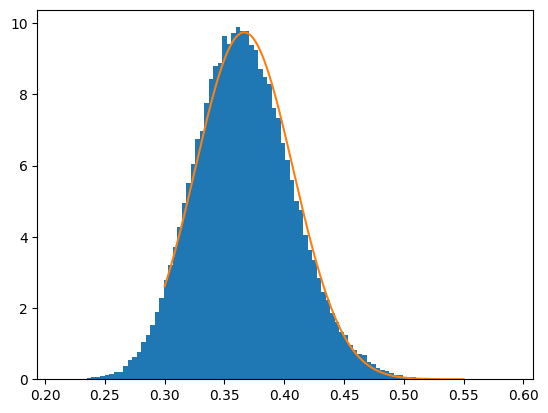

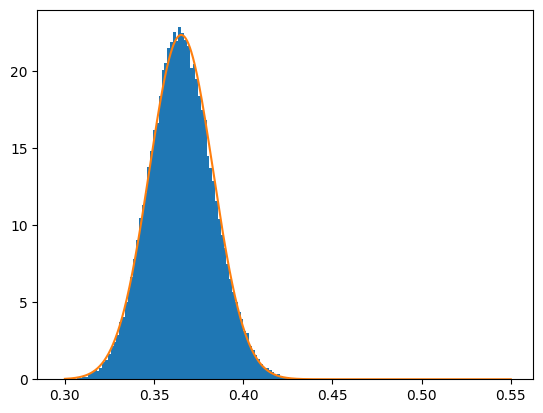

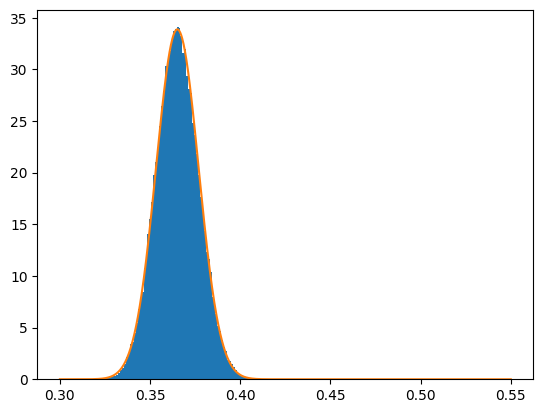

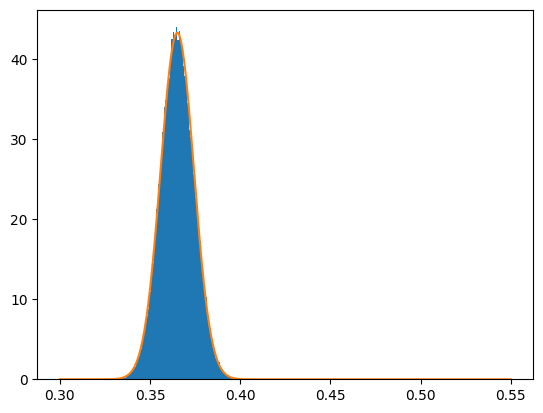

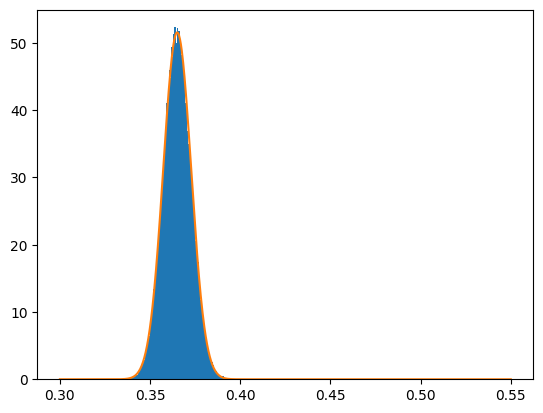

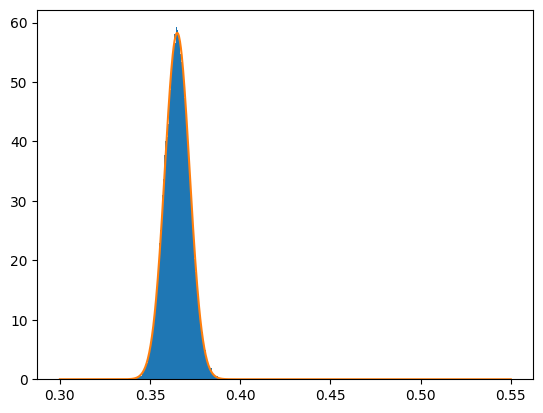

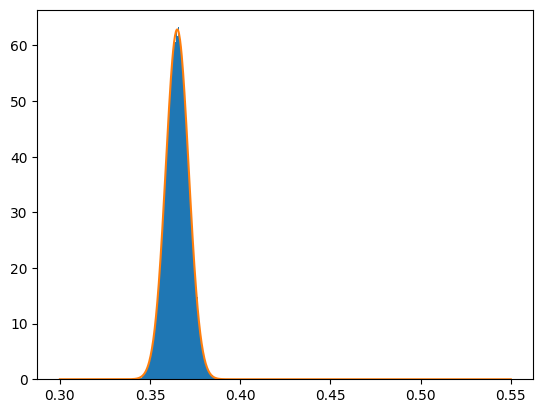

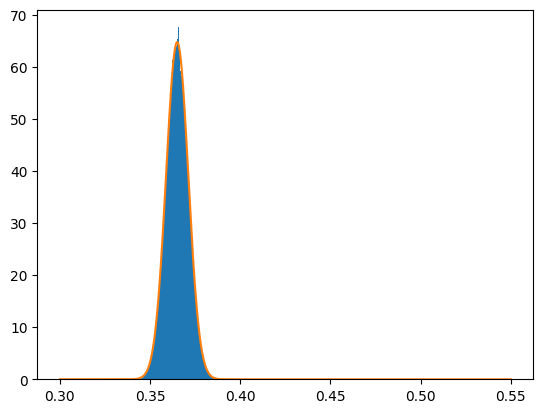

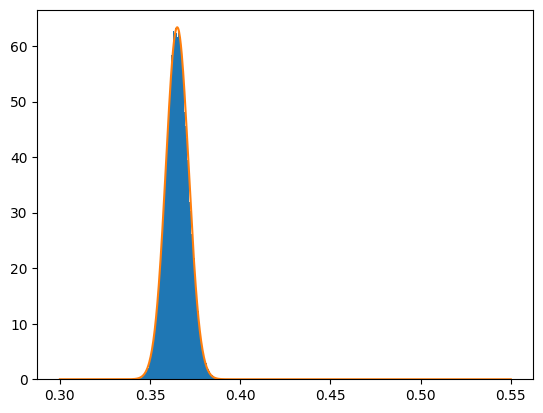

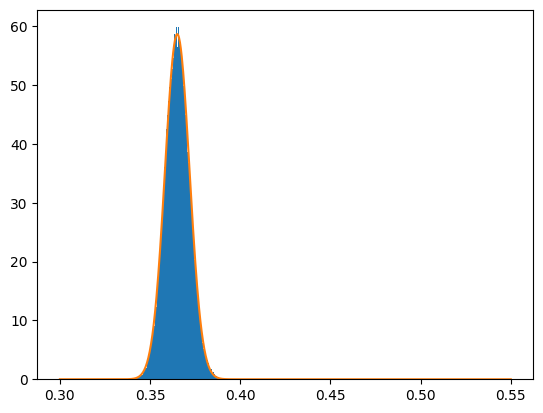

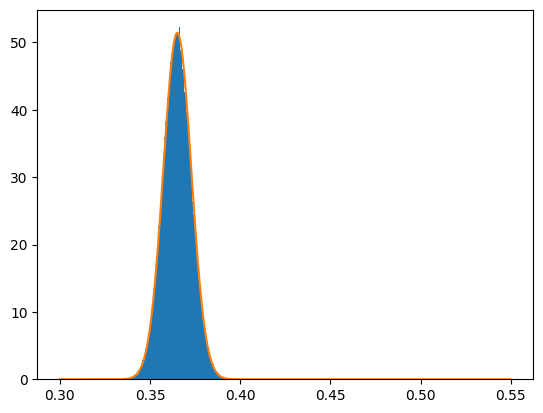

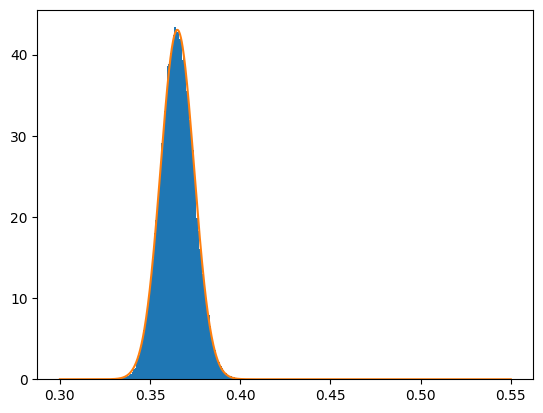

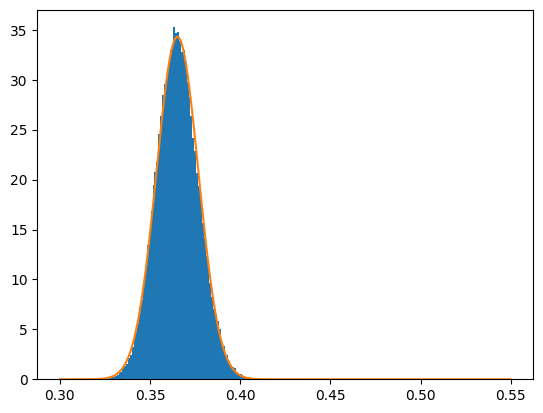

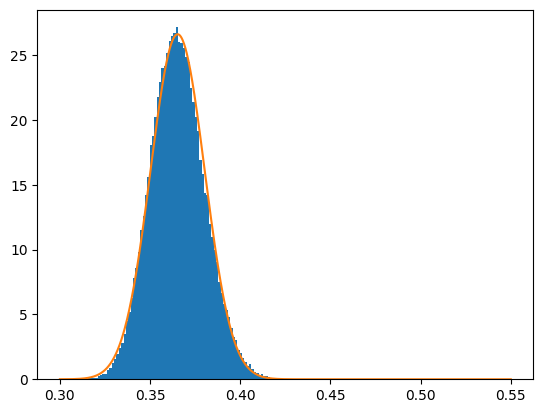

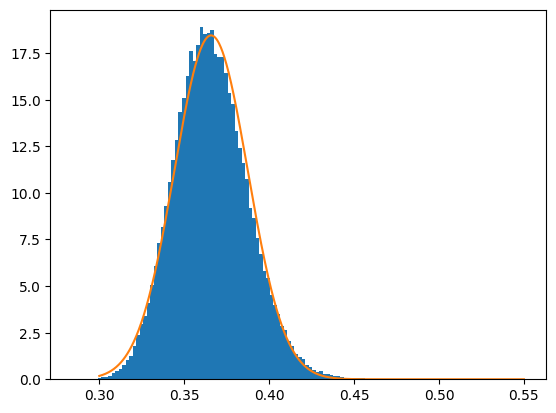

In [26]:
# Visualise in each bin:


EG_plot = np.linspace(0.3,0.55,1000)
EG_means = np.zeros(15)
EG_vars = np.zeros(15)
for i in range(0,15):

    # Find the mean and stddev to plot the Gaussian comparison:
    EG_means[i] = np.mean(EG_samps_from_dvec[:,i])
    EG_vars[i] = np.std(EG_samps_from_dvec[:,i])
    EG_Gauss = scipy.stats.norm(loc=EG_means[i], scale=EG_vars[i])
    pdf = EG_Gauss.pdf(EG_plot)

    plt.figure()
    plt.hist(EG_samps_from_dvec[:,i], bins=100, density=True)
    plt.plot(EG_plot, pdf)
    plt.show()

Compute the fiducial E_G at these parameters (include nonlinear bias) in GR.

In [5]:
# Compute E_G
EG_fid = fid.E_G(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename, nonlin=True)

getting Upgg
getting Upgm
maxchi= 6669.353003473356


Draw many realisations of E_G from the fiducial E_G as mean and the covariance matrix.

In [31]:
# Draw E_G realisations
Nsamp = 10000
EG_samps = np.random.multivariate_normal(EG_fid, egcov, Nsamp)

Brief diversion to plot the distribution of E_G in each r_p bin and check if it is Gaussian.

In [8]:
# Get the mean and variance of E_G in each bin to overplot the relevant Gaussian.

means = np.zeros_like(rp_bin_c)
std = np.zeros_like(rp_bin_c)
for i in range(0, len(rp_bin_c)):
    means[i] = np.mean(EG_samps[:,i])
    std[i] = np.std(EG_samps[:,i])

bin_edges= [0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355 0.36  0.365 0.37  0.375 0.38  0.385 0.39
 0.395 0.4   0.405 0.41  0.415 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475 0.48  0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525 0.53  0.535 0.54  0.545 0.55 ]
bin number = 0 rp =  1.3935788135


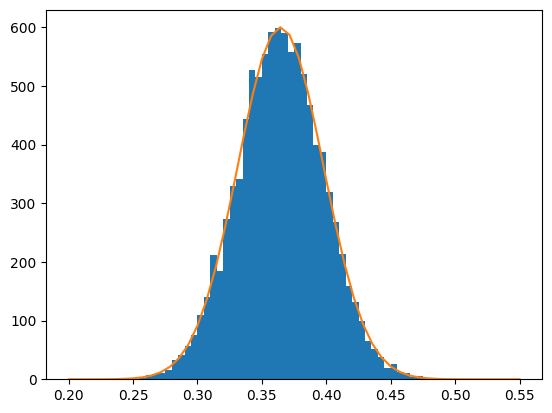

bin number = 1 rp =  1.8370946617


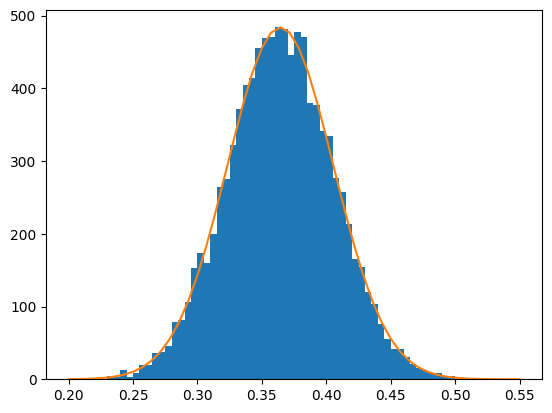

bin number = 2 rp =  2.4217624171


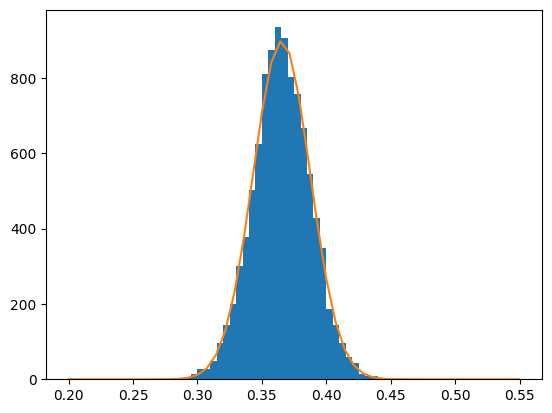

bin number = 3 rp =  3.1925046255


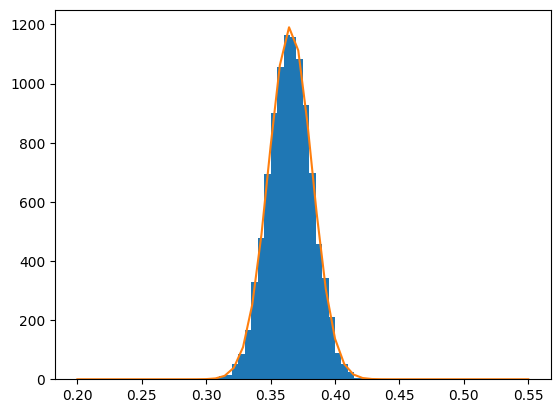

bin number = 4 rp =  4.2085407355


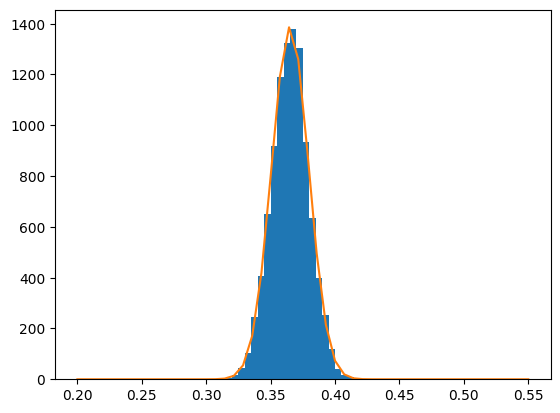

bin number = 5 rp =  5.547937184


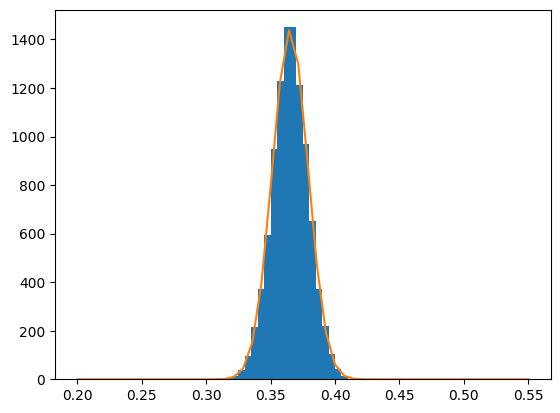

bin number = 6 rp =  7.3136055779


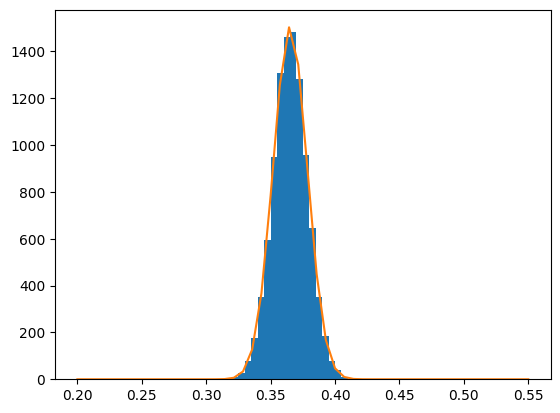

bin number = 7 rp =  9.6412098362


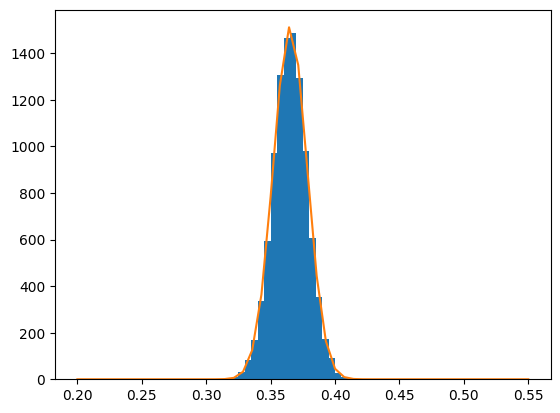

bin number = 8 rp =  12.709589834


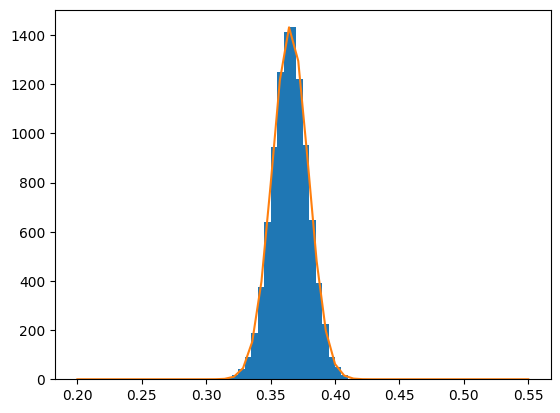

bin number = 9 rp =  16.754502444


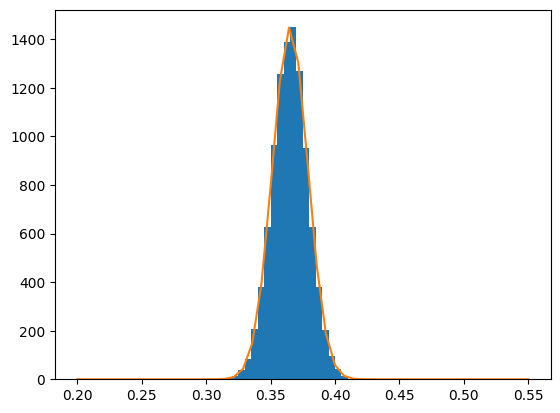

bin number = 10 rp =  22.086735747
This bin is not cut by scale cuts:


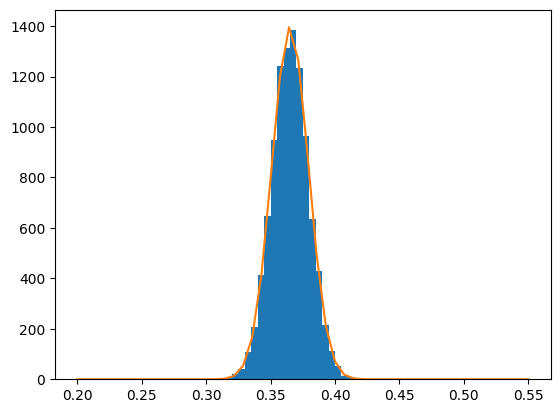

bin number = 11 rp =  29.115988232
This bin is not cut by scale cuts:


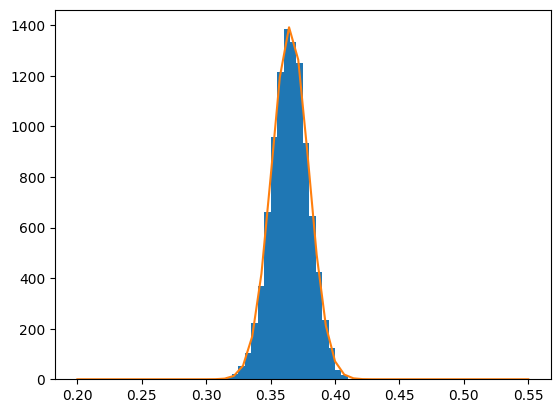

bin number = 12 rp =  38.382347686
This bin is not cut by scale cuts:


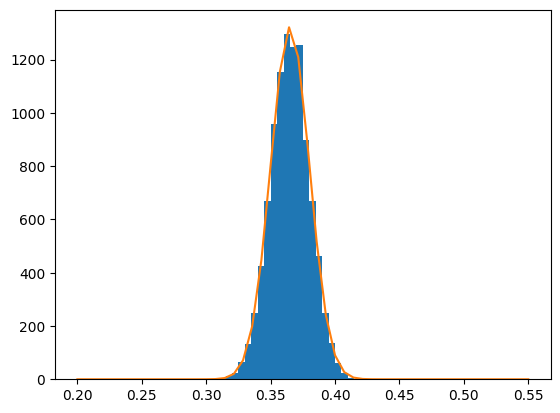

bin number = 13 rp =  50.597788479
This bin is not cut by scale cuts:


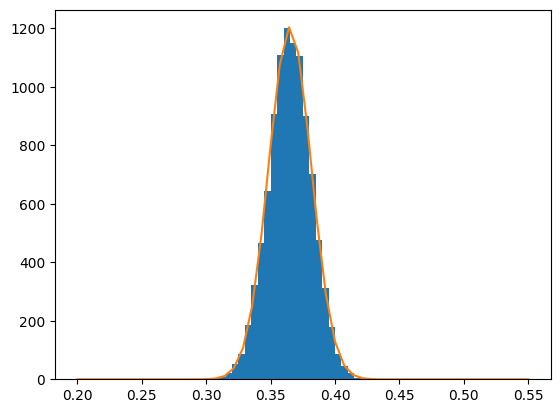

bin number = 14 rp =  66.700875618
This bin is not cut by scale cuts:


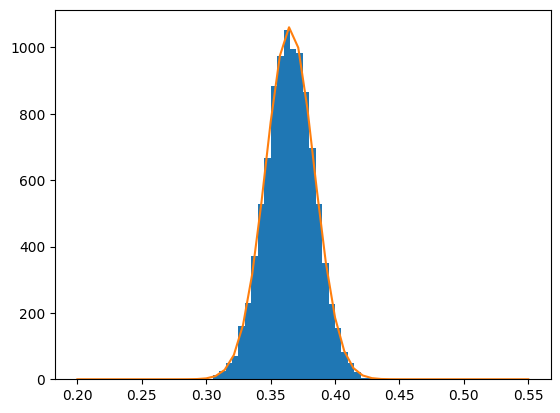

bin number = 15 rp =  87.928878751
This bin is not cut by scale cuts:


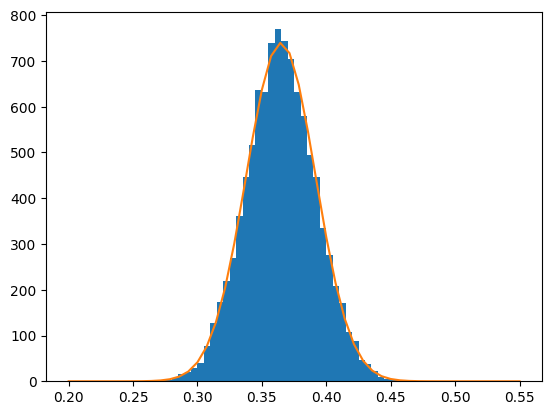

In [9]:
vals = np.linspace(0.2, 0.55)
bin_edges = np.linspace(0.2,0.55,71)
print('bin_edges=', bin_edges)

for i in range(0, len(rp_bin_c)):
    print('bin number =', i, "rp = ", rp_bin_c[i])
    if i>=10:
        print('This bin is not cut by scale cuts:')

    # Get a Gaussian with the same mean and std as the data in this bin.
    
    normal = scipy.stats.norm(means[i], std[i])
    PDF = normal.pdf(vals)

    plt.figure()
    hist_vals = plt.hist(EG_samps[:,i], bin_edges)
    heights= hist_vals[0]
    area = np.sum(heights)*0.005 # 0.01 = bin width
    plt.plot(vals, PDF*area)
    plt.show()

Apply the scale cut to the fiducial and the realisations

In [10]:
# Apply scale cuts

# Get a list of which indices we are cutting:
ind_cut = []
for i in range(0,len(scalecuts)):
    if scalecuts[i] == 0:
        ind_cut = ind_cut + [i]

# Delete these elements from our arrays

EG_samps_cut = np.delete(EG_samps, ind_cut, axis = 1)
egcov_cut = np.delete(np.delete(egcov, ind_cut, axis=0), ind_cut, axis=1)

# And invert the covariance
egcov_cut_inv = np.linalg.inv(egcov_cut)


For each realisation, fit a model which is a constant. The output will be a posterior distribution over the constant value (assuming no prior).

In [11]:
# Define a log likelihood because we probably need this
def logL(model, data, invcov):
    """ model is the constant parameter of the model
    data is the sample of Eg as a function of r_p we are dealing with right now
    invcov is the inverse covariance matrix
    """

    loglike = -0.5*(np.dot(model - data, np.dot(invcov, model - data)))

    return loglike

In [12]:
# Sample the likelihood. It's only a one dimensional parameter space so we can just grid-sample.

vals = np.linspace(0.01,0.99,10000)

loglike_vals = np.zeros((Nsamp, len(vals)))
like_vals = np.zeros((Nsamp, len(vals)))
like_vals_norm = np.zeros((Nsamp, len(vals)))

for i in range(0,Nsamp):
    print('i=',i)
    for j in range(0,len(vals)):
        loglike_vals[i,j] = logL(vals[j], EG_samps_cut[i,:], egcov_cut_inv)
        like_vals[i,j] = np.exp(loglike_vals[i,j])
    like_vals_norm[i,:] = like_vals[i,:]/ scipy.integrate.simps(like_vals[i,:], vals)

i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49
i= 50
i= 51
i= 52
i= 53
i= 54
i= 55
i= 56
i= 57
i= 58
i= 59
i= 60
i= 61
i= 62
i= 63
i= 64
i= 65
i= 66
i= 67
i= 68
i= 69
i= 70
i= 71
i= 72
i= 73
i= 74
i= 75
i= 76
i= 77
i= 78
i= 79
i= 80
i= 81
i= 82
i= 83
i= 84
i= 85
i= 86
i= 87
i= 88
i= 89
i= 90
i= 91
i= 92
i= 93
i= 94
i= 95
i= 96
i= 97
i= 98
i= 99
i= 100
i= 101
i= 102
i= 103
i= 104
i= 105
i= 106
i= 107
i= 108
i= 109
i= 110
i= 111
i= 112
i= 113
i= 114
i= 115
i= 116
i= 117
i= 118
i= 119
i= 120
i= 121
i= 122
i= 123
i= 124
i= 125
i= 126
i= 127
i= 128
i= 129
i= 130
i= 131
i= 132
i= 133
i= 134
i= 135
i= 136
i= 137
i= 138
i= 139
i= 140
i= 141
i= 142
i= 143
i= 144
i= 145
i= 146
i= 147
i= 148
i= 149
i= 150
i= 151
i= 152
i= 153
i= 154
i= 155
i= 156
i= 157
i= 1

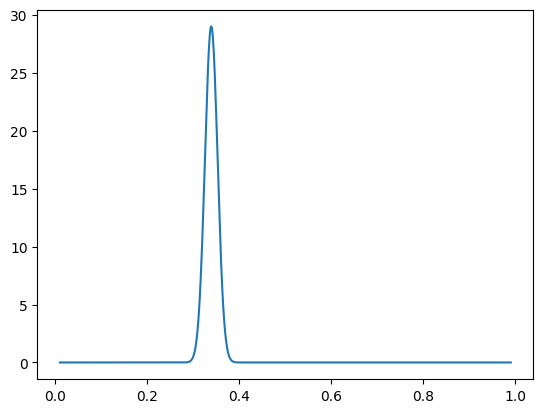

In [19]:
plt.figure()
plt.plot(vals, like_vals_norm[900])
plt.show()

In [13]:
# Now get the maximum of the poterior point of each, which we need for the p-value test of the constant model.
# We could also use the mean. I think it will be pretty similar for the posteriors we are seeing because they appear very Gaussian.

max_post_val = np.zeros(Nsamp)
for i in range(0,Nsamp):
    max_post_ind = np.argmax(like_vals_norm[i,:])
    max_post_val[i] = vals[max_post_ind]

Check for what fraction of the realisations our constant model is consistent with the data and record this. Instances of inconsistency count as instances where we do not correctly identify GR as the underlying theory.

In [14]:
# Get the chi squared for each sample with the constant model.

chisq = np.zeros(Nsamp)
for i in range(0, Nsamp):
    chisq[i] = 0.5*np.dot((max_post_val[i] - EG_samps_cut[i,:]), np.dot(egcov_cut_inv, (max_post_val[i] - EG_samps_cut[i,:])))

In [15]:
# We want to look at a chi squared distribution with the correct number of degrees of freedom
# And calculate the probability that each of our constant E_G models are drawn from this distribution.

# Define the number of degrees of freedom:
len_cut_dvec = len(EG_samps_cut[0,:])
model_par = 1 # 1 parameter for a constant model
DOF = len_cut_dvec - model_par
print(DOF)

3


In [16]:
# What we want is the CDF value at the chi square in each case.
# What this tells us is the probability that, given our constant model is correct, 
# we would have got the chi square we got or a lower chi squared (fixing our measured data vector and cov).
# Eg if CDF = 0.95, this means that if our model is correct, 95% of the time the chi squared would have been lower.
# If we care about the model and the data agreeing within 1 sigma, we look for the case where CDF=0.68 or less
# i.e. the case where if our model is correct, 68% of the time we would have drawn a lower chi-squared. 

cdf_samps = np.zeros(Nsamp)
for i in range(0,Nsamp):
    cdf_samps[i] = chi2.cdf(chisq[i], DOF)

In [17]:
# Check how many of these are >=0.95 and which ones.
const_bad_fit = np.zeros(Nsamp) # Set to 1 where the cdf>=0.95 (corresponds to p value 0.05)
for i in range(0,Nsamp):
    if cdf_samps[i]>=0.95:
        const_bad_fit[i] = 1

num_bad_fit = np.sum(const_bad_fit)

print('num_bad_fit=', num_bad_fit)
print('which ones?=',np.where(const_bad_fit==1))
inds_bad_fit = np.where(const_bad_fit==1)

num_bad_fit= 16.0
which ones?= (array([ 916, 2511, 2595, 3729, 4182, 5237, 6707, 7108, 7283, 7365, 7934, 8153, 8179, 8493, 9030, 9952]),)


Now check for how many of the cases where our constant model passes the PTE test does our constant fit to the 'data' agree with GR. This will tell us the fraction of the time we pass the GR null test.

In [18]:
# Define the theoretical model for GR in terms of cosmological parameters:

def EG_theory(OmM0, z):

    #print((OmM0*(1+z)**3 / (OmM0*(1+z)**3 + (1.0-OmM0))**0.55))
    EG = OmM0/ (OmM0*(1+z)**3 / (OmM0*(1+z)**3 + (1.0-OmM0)))**0.55

    return EG

In [19]:
EG_theory(0.2565, 0.32)

0.4016780167622673

In [20]:
# OmegaM0 has associated uncertainty, which we take as the marginalised uncertainty from the 3x2pt LSSTY1 SRD Fisher matrix.
# We therefore sample over OmegaM0 (assuming this parameter has a Gaussian distribution) to get the distribution over theoretical E_G.

N_theory_samps = 100000
OmMsamps = np.random.normal(OmM, OmM_err, N_theory_samps)

Eg_theory_samps = np.zeros(N_theory_samps)
for i in range(0,N_theory_samps):
    Eg_theory_samps[i] = EG_theory(OmMsamps[i], zbar)

In [21]:
# Get a distribution generated by this histogram:

theory_hist = np.histogram(Eg_theory_samps, bins = 50, density=True)

EG_theory_dist = rv_histogram(theory_hist, density=True)


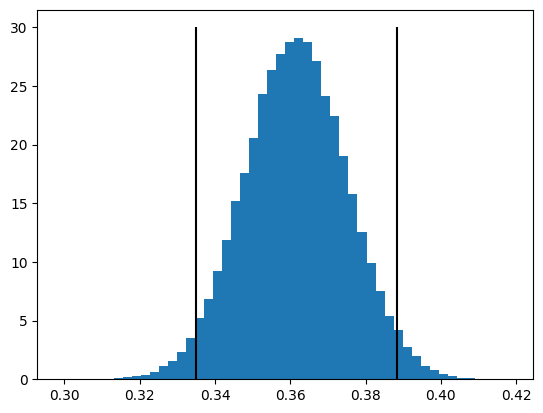

In [23]:
# Get the 5% and 95% confidence points of the theory distribution 

ninetyfive_intervals_theory = EG_theory_dist.interval(0.95)

# Visualise the theory histogram

plt.figure()
plt.hist(Eg_theory_samps, bins = 50, density = True)
plt.vlines(ninetyfive_intervals_theory[0], ymin=0, ymax=30, color='k')
plt.vlines(ninetyfive_intervals_theory[1], ymin=0, ymax=30, color='k')
plt.show()


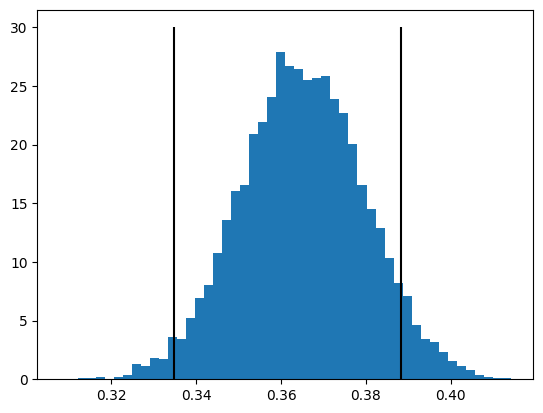

In [24]:
# Visualise the histogram of fitted values:

plt.figure()
plt.hist(max_post_val, bins = 50, density = True)
plt.vlines(ninetyfive_intervals_theory[0], ymin=0, ymax=30, color='k')
plt.vlines(ninetyfive_intervals_theory[1], ymin=0, ymax=30, color='k')
plt.show()


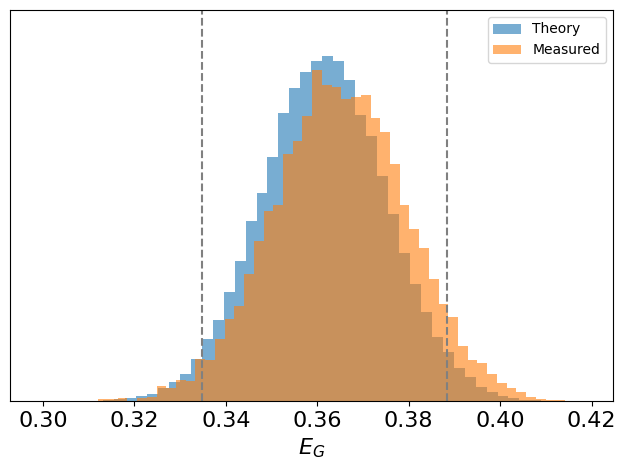

In [28]:
# Visualise both together for paper plotting purposes

plt.figure()
plt.hist(Eg_theory_samps, bins = 50, density = True, label = 'Theory', alpha=0.6)
plt.hist(max_post_val, bins = 50, density = True, label = 'Measured', alpha=0.6)
plt.vlines(ninetyfive_intervals_theory[0], ymin=0, ymax=33, color='grey', linestyle='--')
plt.vlines(ninetyfive_intervals_theory[1], ymin=0, ymax=33, color='grey', linestyle='--')
plt.yticks([])
plt.xlabel('$E_G$', fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0,33)
plt.legend()
plt.tight_layout()
plt.savefig('../plots/EG_distributions_GR_KitanidisWhite2022nLbias.pdf')
plt.show()

In [26]:
# Now, how many of the fit-to-data E_G constant values are outside 95%? 

# First, cut the ones which were already bad fits to a constant:

max_post_cut = np.delete(max_post_val, inds_bad_fit)

# Now figure out how many of the remaining ones are outside the range:

inds_low = np.where(max_post_cut <= ninetyfive_intervals_theory[0])
inds_high = np.where(max_post_cut>= ninetyfive_intervals_theory[1])

total_outside_95 = len(inds_low[0])+ len(inds_high[0])

Now add the total which are a bad fit to the total which are outside the 95% range of the GR prediction to get the percentage that 'fail' the GR null test. 

In [27]:
total_non_GR = total_outside_95+ len(inds_bad_fit)

fraction_non_GR = total_non_GR / len(EG_samps)

print(fraction_non_GR)

print(total_outside_95/len(EG_samps))

0.0757
0.0756


Okay, so we 'fail' the GR null test about 5.5% of the time where by fail we mean we either have a bad fit to a constant value or we draw a value outside the 95% range of the prediction. But this is actually about right given we have defined 'fail' as outside the 95% range of the prediction, so this is basically what we expect. Good.